In [408]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1.Set Up GPU

In [409]:
# 检查是否有可用的GPU，如果有则使用GPU，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 打印出正在使用的设备
print(f"Using device: {device}")

Using device: cuda:0


# 2.Data Processing

## 2.1.Loading Dataset

In [410]:
# 读取训练数据集
train_data = pd.read_csv('./data/stock-forecast/zgpa_train.csv')

# 读取测试数据集
test_data = pd.read_csv('./data/stock-forecast/zgpa_test.csv')

# 打印训练集和测试集的形状，即行数和列数
print(train_data.shape, test_data.shape)

# 打印训练数据集的前几行，以查看数据的格式和内容
print(train_data.head())

(731, 6) (182, 6)
         date   open   high    low  close    volume
0  2016-01-04  30.57  30.57  28.63  28.78  70997200
1  2016-01-05  28.41  29.54  28.23  29.23  87498504
2  2016-01-06  29.03  29.39  28.73  29.26  48012112
3  2016-01-07  28.73  29.25  27.73  28.50  23647604
4  2016-01-08  28.73  29.18  27.63  28.67  98239664


## 2.2.Data Scaling

In [411]:
# 初始化MinMaxScaler对象，设置特征范围为0到1
sc = MinMaxScaler(feature_range=(0,1))

# 从训练数据集中提取收盘价列
train_price = train_data.loc[:, ['close']]
# 从测试数据集中提取收盘价列
test_price = test_data.loc[:, ['close']]

# 使用训练数据对MinMaxScaler进行拟合，并转换训练数据
train_scaled = sc.fit_transform(train_price)
# 使用相同的MinMaxScaler参数转换测试数据
test_scaled = sc.transform(test_price)  # 注意这里应该使用transform而不是fit_transform

## 2.3.Visualize the Feature Trends

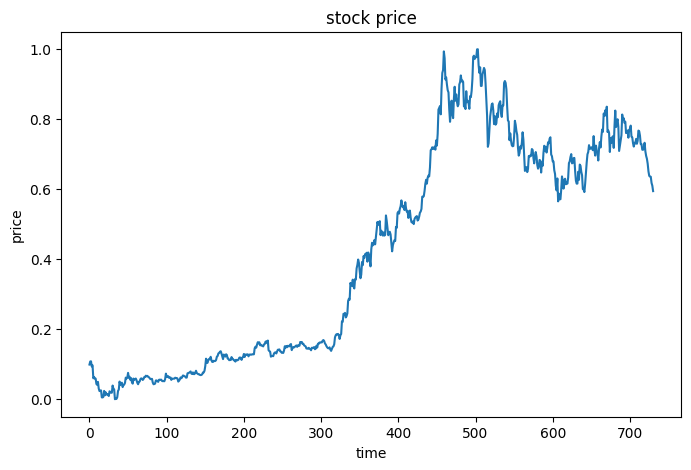

In [412]:
plt.figure(figsize=(8, 5))
plt.plot(train_scaled)
plt.title('stock price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

## 2.4.Construct A Data Extraction Function

In [413]:
# 定义一个函数，用于从数据中提取特征和标签
def extract_data(data, time_step):
    X, y = [], []  # 初始化特征和标签列表
    # 遍历数据，提取特征和标签
    for i in range(len(data) - time_step):
        X.append([j for j in data[i:i + time_step]])  # 提取时间步长为time_step的特征
        y.append([data[i + time_step]])  # 提取对应的标签
    
    # 将特征和标签转换为PyTorch张量，并调整形状
    X = torch.tensor(X)
    X = X.reshape(-1, time_step, 1)  # 调整特征张量的形状
    y = torch.tensor(y)
    y = y.reshape(-1, 1)  # 调整标签张量的形状
    
    return X, y  # 返回特征和标签

# 设置时间步长
time_step = 10
# 使用extract_data函数提取训练数据的特征和标签
X_train, y_train = extract_data(train_scaled, time_step)
# 使用extract_data函数提取测试数据的特征和标签
X_test, y_test = extract_data(test_scaled, time_step)

## 2.5.Create DataLoader

In [414]:
# 设置批量大小为32
batch_size = 32

# 创建训练数据集
train_dataset = TensorDataset(X_train, y_train)
# 创建测试数据集
test_dataset = TensorDataset(X_test, y_test)

# 创建训练数据加载器，设置批量大小为32，并且数据打乱
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# 创建测试数据加载器，设置批量大小为32，数据不打乱
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3.Construct A Model

## 3.1.Construct An RNN

In [415]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RNN, self).__init__()
        # 初始化一个RNN层，参数包括输入大小、隐藏层大小、层数、是否使用batch_first模式、dropout率
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3
        )
        # 初始化一个线性层，用于将RNN的输出映射到最终的输出大小
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        # 前向传播函数，输入x为序列数据，hidden为初始隐藏状态（可选）
        out, hidden = self.rnn(x, hidden)
        # 只取序列最后一个时间步的输出
        out = self.linear(out[:, -1, :])  
        return out, hidden

## 3.2.Construct A Loss Function And An Optimizer

In [416]:
# 定义一个RNN模型并将其发送到指定的设备（如GPU）
model = RNN().to(device)
print(model)

# 定义损失函数为均方误差损失（MSE Loss）
criterion = nn.MSELoss()
# 定义优化器为AdamW，学习率为0.001
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

RNN(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


# 4.Training Loop

## 4.1.Training

In [417]:
# 设置训练的总轮数
epochs = 50
# 初始化最佳损失值，初始设为一个较大的数
best_loss = 9999

# 初始化训练损失和验证损失的历史记录列表
train_loss_history = []
val_loss_history = []

# 进行epochs轮的训练
for epoch in range(epochs):
    # 将模型设置为训练模式
    model.train()
    train_losses = []
    
    # 遍历训练数据集
    for X, y in train_loader:
        # 将数据移动到指定的设备上，并转换为浮点数
        X, y = X.to(device).float(), y.to(device).float()
        
        # 清空梯度
        optimizer.zero_grad()
        # 进行前向传播
        outputs, _ = model(X)
        # 计算损失
        loss = criterion(outputs, y)
        # 反向传播
        loss.backward()
        # 更新模型参数
        optimizer.step()
        
        # 记录训练损失
        train_losses.append(loss.item())
    
    # 计算平均训练损失
    train_loss = sum(train_losses) / len(train_losses)
    # 将平均训练损失添加到历史记录中
    train_loss_history.append(train_loss)
    
    # 将模型设置为评估模式
    model.eval()
    val_losses = []
    
    # 在不计算梯度的情况下进行验证
    with torch.no_grad():
        for X, y in test_loader:
            # 将数据移动到指定的设备上，并转换为浮点数
            X, y = X.to(device).float(), y.to(device).float()
            # 进行前向传播
            outputs, _ = model(X)
            # 计算损失
            loss = criterion(outputs, y)
            # 记录验证损失
            val_losses.append(loss.item())
            
    # 计算平均验证损失
    val_loss = sum(val_losses) / len(val_losses)
    # 将平均验证损失添加到历史记录中
    val_loss_history.append(val_loss)
    
    # 如果当前轮的验证损失是最佳，则更新最佳损失值
    if val_loss < best_loss:
        best_loss = val_loss
            
    # 每10轮打印一次训练和验证的损失情况
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}:')
        print(f'\tTrain loss: {train_loss:.8f}')
        print(f'\tVal loss: {val_loss:.8f}')
        print(f'\tBest val loss: {best_loss:.8f}')
        print('*' * 50)

Epoch 1:
	Train loss: 0.09008470
	Val loss: 0.26724740
	Best val loss: 0.26724740
**************************************************
Epoch 11:
	Train loss: 0.00226428
	Val loss: 0.01340213
	Best val loss: 0.00499235
**************************************************
Epoch 21:
	Train loss: 0.00176317
	Val loss: 0.01342030
	Best val loss: 0.00499235
**************************************************
Epoch 31:
	Train loss: 0.00116666
	Val loss: 0.01324690
	Best val loss: 0.00499235
**************************************************
Epoch 41:
	Train loss: 0.00116264
	Val loss: 0.00840581
	Best val loss: 0.00499235
**************************************************


## 4.2.Visualize the Loss Function

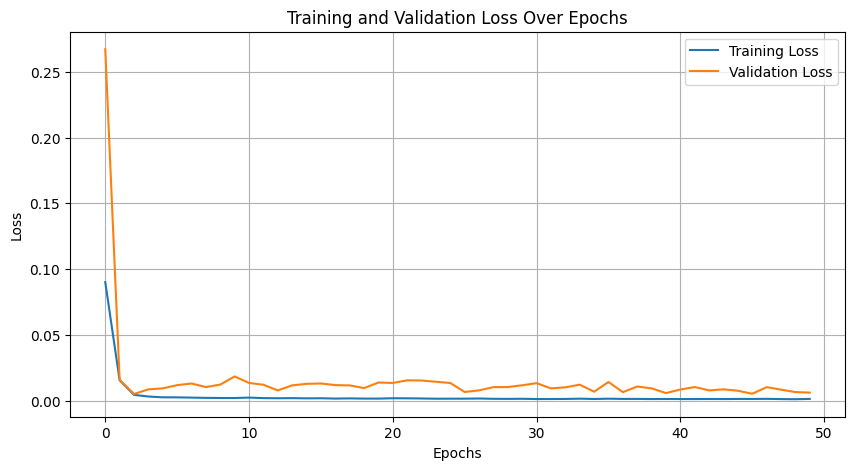

In [418]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 5.Test

In [419]:
# 将模型设置为评估模式，关闭Dropout等训练特有的操作
model.eval()

# 使用torch.no_grad()上下文管理器，避免计算梯度，节省内存和计算资源
with torch.no_grad():
    # 初始化一个空列表，用于存储测试集的预测结果
    test_predictions = []
    # 遍历测试数据加载器
    for X, y in test_loader:
        # 将数据移动到指定设备，并转换为浮点数
        X, y = X.to(device).float(), y.to(device).float()
        # 将输入数据X传入模型，获取预测输出
        outputs, _ = model(X)
        # 将预测输出从GPU移动到CPU，并转换为NumPy数组，然后追加到列表中
        test_predictions.append(outputs.cpu().numpy())

In [420]:
# 将测试预测结果拼接成一个数组
test_predictions = np.concatenate(test_predictions)
# 使用逆变换将测试集的实际价格从标准化形式转换回原始形式
actual_prices = sc.inverse_transform(y_test.cpu().numpy())
# 使用逆变换将预测价格从标准化形式转换回原始形式
predicted_prices = sc.inverse_transform(test_predictions)

In [421]:
# 计算均方误差（Mean Squared Error, MSE），衡量预测值与实际值之间差异的平方的平均值
MSE = mean_squared_error(y.cpu().numpy(), outputs.cpu().numpy())
# 计算平均绝对误差（Mean Absolute Error, MAE），衡量预测值与实际值之间差异的绝对值的平均值
MAE = mean_absolute_error(y.cpu().numpy(), outputs.cpu().numpy())
# 计算R平方值（R2 Score），衡量模型预测的准确度，值越接近1表示模型预测越准确
R2 = r2_score(y.cpu().numpy(), outputs.cpu().numpy())

# 打印MSE、MAE和R2值，用于评估模型性能
print(f"MSE: {MSE}")
print(f"MAE: {MAE}")
print(f"R2: {R2}")

MSE: 0.010285617783665657
MAE: 0.09952488541603088
R2: -19.881696701049805


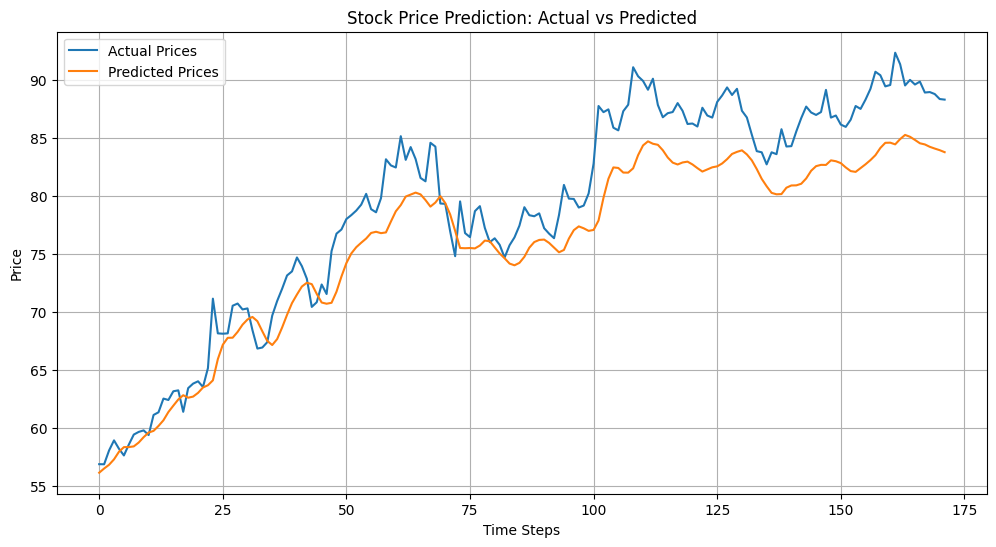

In [422]:
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# 6.Clear GPU Cache

In [423]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()